In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
import math
sns.set()

In [38]:
stock_name='GOOGL'

In [39]:
df = pd.read_csv('../../dataset/5year/'+stock_name+'-5year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-27,567.780029,574.869995,564.150024,574.869995,574.869995,2185800
1,2014-05-28,574.570007,577.659973,569.950012,570.450012,570.450012,1581600
2,2014-05-29,573.390015,573.479980,568.450012,570.559998,570.559998,1411100
3,2014-05-30,571.640015,572.580017,565.789978,571.650024,571.650024,1871700
4,2014-06-02,569.750000,570.409973,556.700012,564.340027,564.340027,1660500


In [40]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

D:\Programming_Software\Anaconda\anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5
0,0.086773,0.093625,0.093801,0.097367,0.097367,0.134971
1,0.095369,0.097127,0.101230,0.091836,0.091836,0.085998
2,0.093875,0.091880,0.099308,0.091974,0.091974,0.072178
3,0.091660,0.090751,0.095902,0.093338,0.093338,0.109512
4,0.089267,0.088027,0.084260,0.084191,0.084191,0.092393


In [41]:
train_percentage=0.67
df_train=df_log[:math.ceil(train_percentage*df_log.shape[0])]
df_test=df_log[math.ceil(train_percentage*df_log.shape[0]):]

In [42]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        self.residue=self.Y - self.logits

In [43]:
num_layers = 1
size_layer = 6
timestamp = 5
epoch = 200
dropout_rate = 0.3
future_day = 10

In [44]:
tf.reset_default_graph()
modelnn = Model(
    0.01, num_layers, df_train.shape[1], size_layer, df_train.shape[1], dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

D:\Programming_Software\Anaconda\anaconda\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [45]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_train.shape[0] - 1, timestamp):
        #print(k)
        index = min(k + timestamp, df_train.shape[0] -1)
        batch_x = np.expand_dims(
            df_train.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_train.iloc[k + 1 : index + 1, :].values
        last_state, _, loss,residue = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost,modelnn.residue],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        if i==epoch-1:
            if k==0:
                last_residue=residue
            else:
                last_residue=np.vstack((last_residue,residue))
        init_value = last_state
        total_loss += loss
    total_loss /= df_train.shape[0] // timestamp
    if (i + 1) % 50 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)


epoch: 50 avg loss: 0.013742363567178558
epoch: 100 avg loss: 0.012685966285581734
epoch: 150 avg loss: 0.01236025815905166
epoch: 200 avg loss: 0.012923546556564924


In [46]:
last_residue.shape

(843, 6)

In [47]:
inv_residue=minmax.inverse_transform(last_residue)
#print(inv_residue)
print(np.std(inv_residue[:,4]))
resid_std=np.std(inv_residue[:,4])

94.30528


In [48]:
output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
output_predict[0] = df_train.iloc[0]
upper_b = (df_train.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_train.iloc[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
df_train.loc[df_train.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

D:\Programming_Software\Anaconda\anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
def forecast(sess,future_day,test_x,state):
    output=np.zeros((future_day,test_x.shape[1]))
    for i in range(future_day):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(test_x, axis = 0),
                modelnn.hidden_layer: state,
            },
        )
        state = last_state
        output[i] = out_logits[-1]
    return output

In [50]:
merge_pre=np.ones((df_test.shape[0]-timestamp-future_day,df_test.shape[1]))
for i in range(df_test.shape[0]-timestamp-future_day):
    test_x=df_test.iloc[i:i+timestamp,:]
    output=forecast(sess,future_day,test_x,init_value)
    output_inv=minmax.inverse_transform(output)
    merge_pre[i]=output_inv[-1]
#     print(output_inv[-1])

In [51]:
y_test=df_test.iloc[-(df_test.shape[0]-timestamp-future_day):,:]
print(y_test.shape)

(400, 6)


In [52]:
# inv_yhat=minmax.inverse_transform(merge_pre)
inv_yhat=merge_pre.copy()
inv_test=minmax.inverse_transform(y_test)
upper_list,lower_list,rvalue_list,pvalue_list=[],[],[],[]
for i in range(inv_yhat.shape[0]):
    pvalue=inv_yhat[i,4]
    upper_bound=pvalue+1.15*resid_std*math.sqrt(future_day)
    lower_bound=pvalue-1.15*resid_std*math.sqrt(future_day)
    rvalue=inv_test[i,4]
    print(i,upper_bound,lower_bound,rvalue)
    upper_list.append(upper_bound)
    lower_list.append(lower_bound)
    rvalue_list.append(rvalue)
    pvalue_list.append(pvalue)

0 1285.88032062461 599.9754973529252 1005.0700073242188
1 1285.880368257063 599.9755449853783 985.5399780273438
2 1351.1770783733898 665.272255101705 988.489990234375
3 1285.915425742516 600.0106024708311 991.4600219726562
4 1347.5339102010237 661.6290869293389 991.4199829101562
5 1285.9048037054833 599.9999804337986 1033.6700439453125
6 1285.8942769333569 599.9894536616721 1033.1300048828125
7 1285.895181949965 599.9903586782802 1033.0400390625
8 1354.2508958343185 668.3460725626337 1042.5999755859375
9 1352.1405876339065 666.2357643622217 1042.969970703125
10 1285.915425742516 600.0106024708311 1049.989990234375
11 1349.743055741537 663.8382324698523 1042.6800537109375
12 1285.902183920565 599.9973606488802 1052.3900146484375
13 1285.8884657740834 599.9836425023987 1058.2900390625
14 1349.1322647959366 663.2274415242518 1047.719970703125
15 1285.8984685892262 599.9936453175414 1044.1500244140625
16 1285.9119009409894 600.0070776693046 1041.199951171875
17 1285.9132346496751 600.00841

In [53]:
print(pvalue_list)
print(rvalue_list)

[942.9279089887676, 942.9279566212207, 1008.2246667375474, 942.9630141066735, 1004.5814985651813, 942.952392069641, 942.9418652975145, 942.9427703141226, 1011.2984841984761, 1009.1881759980641, 942.9630141066735, 1006.7906441056947, 942.9497722847226, 942.936054138241, 1006.1798531600942, 942.9460569533838, 942.959489305147, 942.9608230138327, 1009.3507455603611, 1004.3294752560358, 942.9525349670001, 1010.8095370678055, 942.9601561594899, 1011.4037042872877, 942.9472477647104, 942.9630141066735, 942.9630141066735, 942.9568218877756, 942.9486291058491, 1013.8740662003873, 942.9466285428206, 942.9372925820206, 942.9498675496287, 942.9630141066735, 1016.6255548514526, 942.9607277489266, 942.9585366560858, 942.9607277489266, 999.6373452023616, 1004.3433839323296, 942.9531065564369, 942.9522015398287, 942.9503915066124, 942.9630141066735, 1009.29206237819, 1009.6762657445796, 942.9533447187022, 1007.9936493402018, 942.9569171526817, 942.9630141066735, 942.9622519874246, 942.958679553445, 1

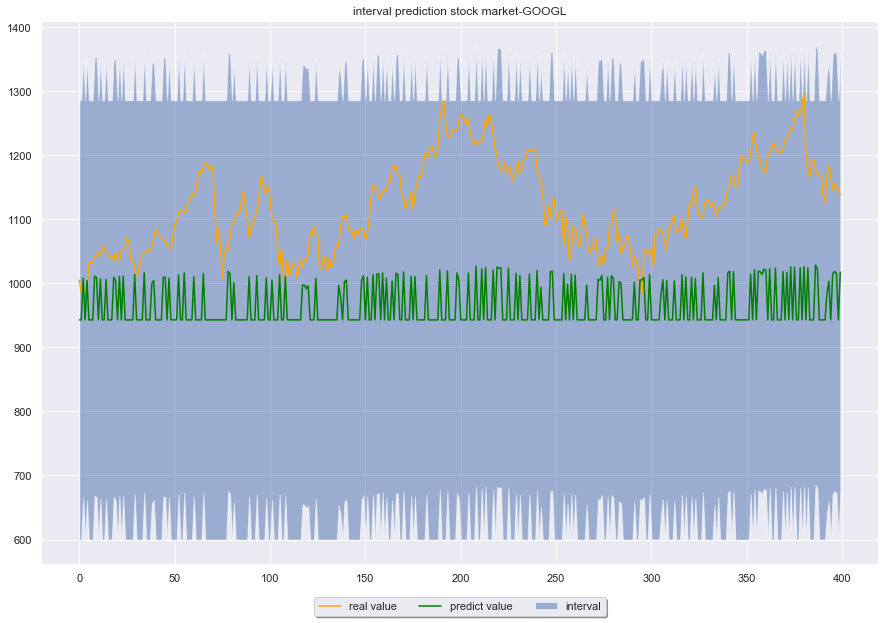

In [54]:
plt.figure(figsize = (15, 10))
plt.fill_between([k for k in range(len(upper_list))],upper_list,lower_list,label='interval',alpha=0.5)
plt.plot(rvalue_list,label='real value',color='orange')
plt.plot(pvalue_list,label='predict value',color='green')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('interval prediction stock market-%s'%stock_name)
# plt.savefig('../../image/Interval/'+stock_name+'+10.png')
plt.show()

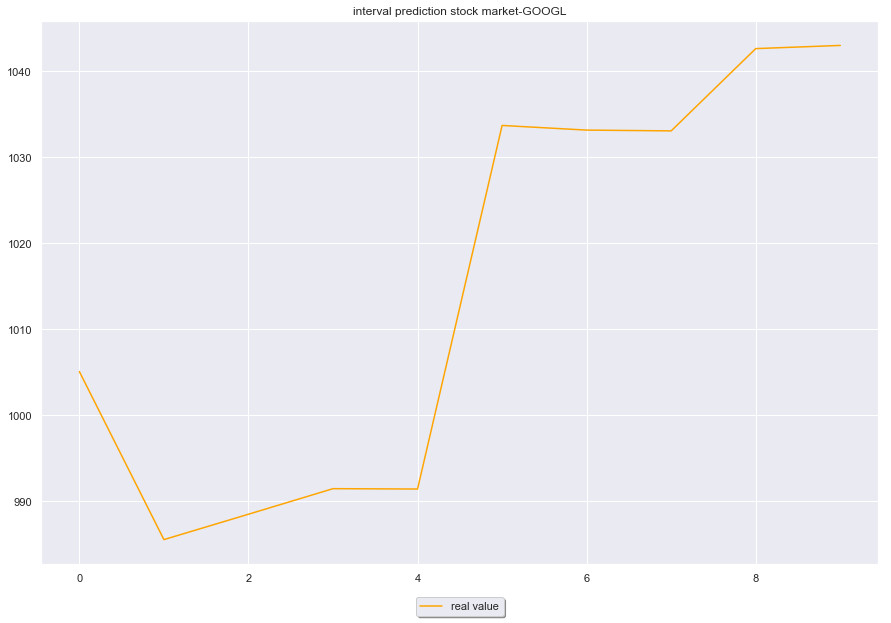

In [55]:
plt.figure(figsize = (15, 10))
plt.plot(inv_test[:10,4],label='real value',color='orange')
# plt.plot(inv_yhat[-future_day:,4],label='predict value',color='green')
plt.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('interval prediction stock market-GOOGL')
plt.show()